In [1]:
from time import time
import os, sys, csv
import numpy as np
from pylab import *
import pylab as pylab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats


from kpal.klib import Profile

import pandas as pd


from sklearn import manifold
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

import umap
from sklearn.datasets import load_digits
from Bio import SeqIO
from io import StringIO
import sys

from itertools import combinations
from scipy.sparse import dok_matrix
from operator import add

/home/jacob/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ordered_genome_labels = {'Acetobacter pasteurianus':0,
                         # Acetobacter pasteurianus; 
                            # Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales;
                            # Acetobacteraceae; Acetobacter"""
                         
                        'Flavobacterium branchiophilum':1,\
                         #C_016001.;
                          #  Bacteria; Bacteroidetes; Flavobacteriia; Flavobacteriales;
                           # Flavobacteriaceae; Flavobacterium."""
                         
                        'Halothiobacillus neapolitanius':2,\
                         #Halothiobacillus neapolitanius;
                            #Bacteria; Proteobacteria; Gammaproteobacteria; Chromatiales;
                            #Halothiobacillaceae; Halothiobacillus."""
                         
                        'Lactobacillus casei':3,\
                         #Lactobacillus casei;
                         #Bacteria; Firmicutes; Bacilli; Lactobacillales; Lactobacillaceae;
                         #Lactobacillus."""
                         
                        'Nitrosococcus watsonii':4,\
                         #Nitrosococcus watsonii;
                         #Bacteria; Proteobacteria; Gammaproteobacteria; Chromatiales;
                         #Chromatiaceae; Nitrosococcus."""
                         
                        'Odoribacter splanchnicus':5,\
                         #Odoribacter splanchnicus;
                         #Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales;
                         #Odoribacteraceae; Odoribacter.
                         
                        'Rhodococcus jostii':6,\
                         #Rhodococcus jostii
                         #Bacteria; Actinobacteria; Corynebacteriales; Nocardiaceae;
                         #Rhodococcus.
                         
                        'S. pneumoniae CGSP14':7,\
                         #S. pneumoniae CGSP14
                         #Bacteria; Firmicutes; Bacilli; Lactobacillales; Streptococcaceae;
                         #Streptococcus."""
                         
                        'Thermoanaerobacter X513':8,\
                         #Thermoanaerobacter X513
                         #Bacteria; Firmicutes; Clostridia; Thermoanaerobacterales;
                         #Thermoanaerobacteraceae; Thermoanaerobacter."""
                         
                        #Xanthobacter autotrophicus
                        #Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales;
                        #Xanthobacteraceae; Xanthobacter."""
                        'Xanthobacter autotrophicus':9}
inv_genome_labels = {v: k for k, v in ordered_genome_labels.items()}


def calc_kmer_freqs(split_seqs, kmer_size):
    '''
    Use kpal to calculate kmer frequencies for split sequences
    '''

    kmer_freqs = []
    for seq in split_seqs:
        temp_list = []

        #for some reason this kmer counter function only works on iterable(str) type objects.
        temp_list.append(str(seq))
        ktable = Profile.from_sequences(temp_list, kmer_size, name=None)

        #skip sequences with a lot of Ns/characters besides A|T|C|G
        if len(str(seq)) < 3000:
            if ktable.total >= len(str(seq))/2:
                ktable.counts = [count/ktable.total for count in ktable.counts]
                kmer_freqs.append(ktable.counts)
        else:
            if ktable.total >= 1500:
                ktable.counts = [count/ktable.total for count in ktable.counts]
                kmer_freqs.append(ktable.counts)

    return kmer_freqs

def chunk_sequence(sequence, min_size, max_size):
    '''
    Cut sequences longer than 5kb into 5kb chunks and exclude trailing sequences
    if shorter than user specified min_length
    '''

    split_seqs = []
    while True:
        chunk = sequence.read(max_size)
        if len(chunk) >= min_size:
            split_seqs.append(chunk)
        else:
            break

    return split_seqs

if not os.path.exists('contig_labels.npy'):
    contig_labels = []

    real_contig_list = []
    for record in SeqIO.parse('/home/jacob/Documents/Jacob/Maxbin_Simulated_80x_metagenome.scaffold.fasta', "fasta"):
        real_contig_list.append(record.id)

    #Contigs don't show up in blast log at all; I'm assuming assembly errors. Label them with 0 and be done with it.
    stupid_list = []
    for contig in real_contig_list:
        if contig not in unique_contig_names:
            stupid_list.append(contig)

    for index, contig in enumerate(real_contig_list):
        #Take rows of dataframe corresponding to 
        if contig not in stupid_list:
            aln_blast_contig = aln_blast[aln_blast.qseqid == contig]
            aln_blast_contig_sorted = aln_blast_contig.sort_values(by=['bitscore'])
            try:
                origin_genome = aln_blast_contig_sorted['sseqid'].iloc[0].split('|')[1]
            except:
                print(index)
                print(contig)
                print(aln_blast_contig)
                print(aln_blast_contig_sorted['sseqid'].iloc[0])

            label = ordered_genome_labels[origin_genome]
            contig_labels.append(label)
        else:
            contig_labels.append(0)
        contig_labels = np.array(contig_labels)
        np.save('contig_labels.npy', contig_labels)
else:
    contig_array = np.load('pentamer_fixed_labels.npy')
    contig_labels = contig_array
    
#15701 contigs in simulated metagenome; use 5-mers for vector generation
if not os.path.exists('pentamer.npy'):
    pentamer_list = []
    for record in SeqIO.parse('/home/jacob/Documents/Jacob/Maxbin_Simulated_80x_metagenome.scaffold.fasta', "fasta"):
        s = StringIO(str(record.seq))
        split_seqs = []
        kmer_freqs = []
        seq_name = record.id

        #split sequence into 5kb max_size chunks
        #split_seqs = chunk_sequence(s, min_size, max_size)

        #Calculate kmer frequences for each chunk
        #kmer_freqs = calc_kmer_freqs(seq_name, 5)
        temp_list = []

        #for some reason this kmer counter function only works on iterable(str) type objects.
        temp_list.append(str(record.seq))
        ktable = Profile.from_sequences(temp_list, 5, name=None)

        ktable.counts = [count/ktable.total for count in ktable.counts]
        pentamer_list.append(ktable.counts)
        pentamer_array = np.array(pentamer_list)

else:
    pentamer_array = np.load('pentamer_fixed_data.npy')

In [3]:
def umap_embed_3(neighbors, metric):
    u_embedding = umap.UMAP(n_components=3,
                            n_neighbors=neighbors,
                            min_dist=0.3,
                            metric=metric).fit_transform(pentamer_array)
    return u_embedding

def tsne_embed_3(perplexity):
    tsne = TSNE(n_components=3,perplexity=perplexity,n_jobs=8)
    t_embedding = tsne.fit_transform(pentamer_array)
    return t_embedding

def plot_meta_3(embedding, metric, method):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cmspec = plt.cm.nipy_spectral(np.linspace(0, 1, 10))    
    
    for i in range(10):
        red_embedding = []
        for index, element in enumerate(embedding):
            if contig_labels[index] == i:
                red_embedding.append(element.tolist())
        red_embedding = np.array(red_embedding)
        ax.scatter(red_embedding[:,0], \
                   red_embedding[:,1], \
                   red_embedding[:,2], \
                   color=cmspec[i], label=inv_genome_labels[i])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title("3D Embedding: " + method + " " + metric)
    pylab.show()
    return

def plot_meta_3t(embedding, metric):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cmspec = plt.get_cmap("nipy_spectral")

    ax.scatter(embedding[:,0], \
              embedding[:,1], \
              embedding[:,2], \
              c=contig_labels, cmap=cmspec)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    pylab.title("3D Embedding: " + metric)
    pylab.show()
    return

def umap_embed(neighbors, metric):
    u_embedding = umap.UMAP(n_neighbors=10,
                          min_dist=0.3,
                          metric='minkowski').fit_transform(pentamer_array)
    return u_embedding

def tsne_embed_fun():
    tsne = TSNE(n_jobs=4)
    return tsne.fit_transform(pentamer_array)

def plot_meta(u_embedding, metric):
    colors = [int(i % 10) for i in contig_labels]
    pylab.scatter(u_embedding[:,0], u_embedding[:,1],c=colors,cmap=pylab.cm.spectral)
    pylab.title("UMAP - Metagenome (Sim, "+ metric+ ")")
    pylab.show()
    return

def train_and_score(em, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(em, contig_labels, test_size=test_size)
    Uclf = svm.SVC(kernel=kernel, C=1).fit(X_train, y_train)
    return Uclf.score(X_test,y_test)

def run_nonsense(neighbors):
    u_euc_scores = []
    u_mah_scores = []
    u_cor_scores = []
    tsne_scores = []

    for i in range(5):
        euc_embed = umap_embed(neighbors, 'euclidean')
        u_euc_scores.append(train_and_score(euc_embed, 0.4, 'rbf'))

        mah_embed = umap_embed(neighbors, 'mahalanobis')
        u_mah_scores.append(train_and_score(mah_embed, 0.4, 'rbf'))

        cor_embed = umap_embed(neighbors, 'correlation')
        u_cor_scores.append(train_and_score(cor_embed, 0.4, 'rbf'))

        tsne_embedding = tsne_embed_fun()
        tsne_scores.append(train_and_score(tsne_embedding, 0.4, 'rbf'))
        print("loop " + str(i) + " complete.")
        return u_euc_scores, u_mah_scores, u_cor_scores, tsne_scores
def u_run_nonsense(metrics):
    scores = []
    for metric in metrics:
        print('---------------------------------------------------------------')
        print('                       ' + metric + '                          ')
        print('---------------------------------------------------------------')
        scores.append([])
        for i in range(9):
            u_embedding = umap_embed_3(10+10*i, metric)
            plot_meta_3(u_embedding, 'UMAP', metric + ' (n=' + str(10+10*i)+')')
            score = train_and_score(u_embedding, 0.4, 'rbf')
            scores[-1].append(score)
            print(score)
        print(metric + " average classification score: ", np.mean(scores[-1]))
    return scores

In [7]:
u_embedding = umap_embed_3(80, 'manhattan')

In [40]:
cmspec = plt.get_cmap("tab10")
cmspec(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

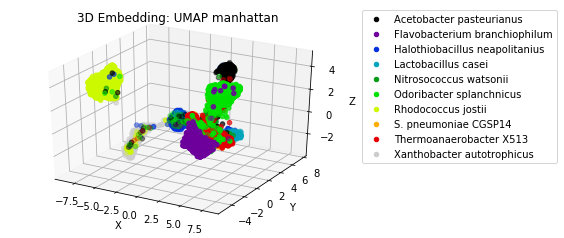

In [67]:
def plot_meta_3_labeltest(embedding, metric, method):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cmspec = plt.cm.nipy_spectral(np.linspace(0, 1, 10))    
    
    for i in range(10):
        red_embedding = []
        for index, element in enumerate(embedding):
            if contig_labels[index] == i:
                red_embedding.append(element.tolist())
        red_embedding = np.array(red_embedding)
        ax.scatter(red_embedding[:,0], \
                   red_embedding[:,1], \
                   red_embedding[:,2], \
                   color=cmspec[i], label=inv_genome_labels[i])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title("3D Embedding: " + method + " " + metric)
    pylab.show()
    return

plot_meta_3_labeltest(u_embedding, 'manhattan', 'UMAP')

---------------------------------------------------------------
                       manhattan                          
---------------------------------------------------------------


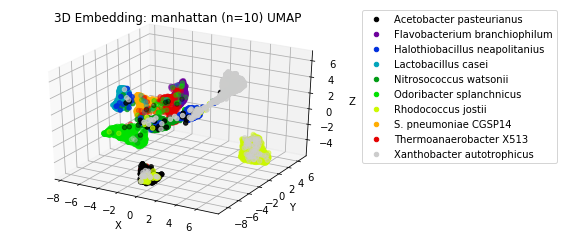

0.9368809030177379


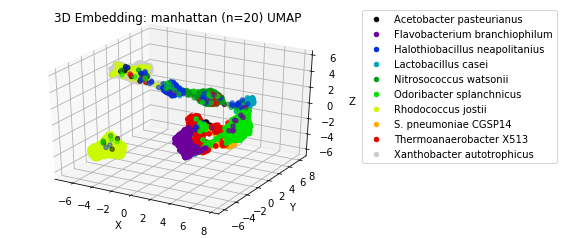

0.9345772863395531


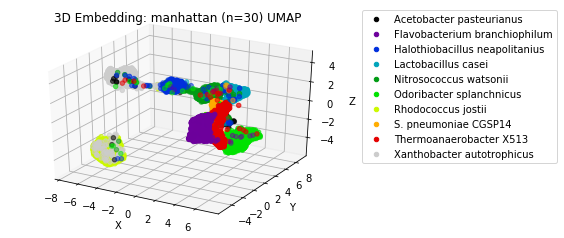

0.9373416263533748


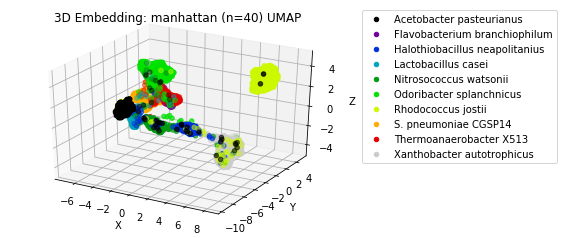

0.9334254780004607


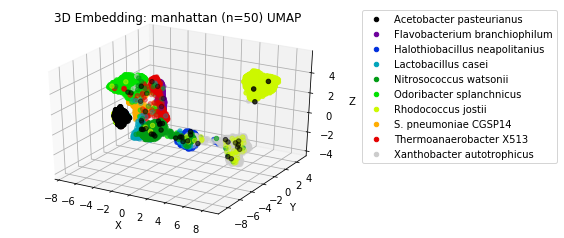

0.9341165630039161


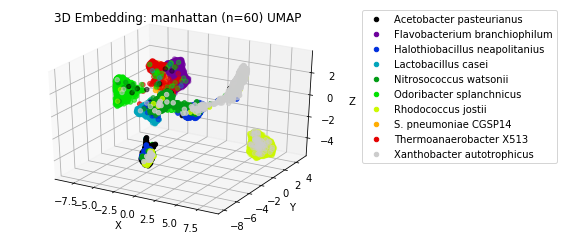

0.9308914996544575


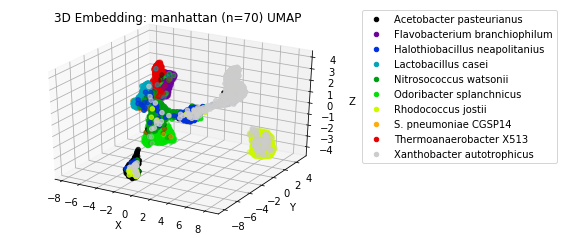

0.9322736696613684


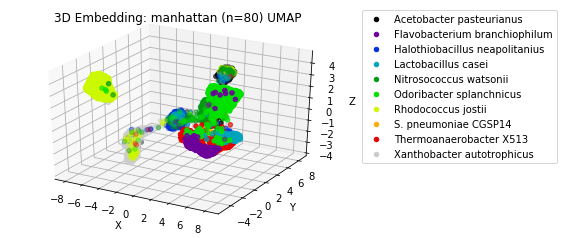

0.9315825846579129


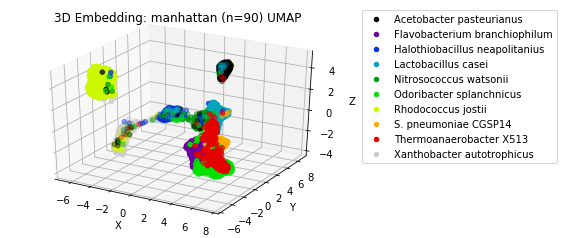

0.9320433079935498
manhattan average classification score:  0.9336814354091479
---------------------------------------------------------------
                       canberra                          
---------------------------------------------------------------


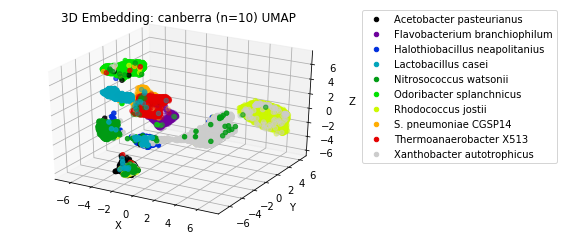

0.9274360746371804


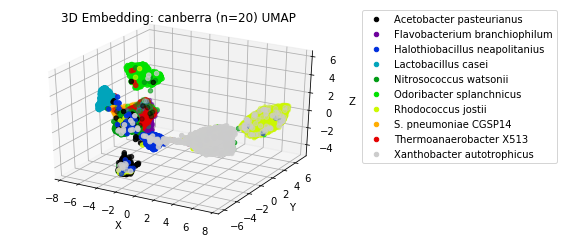

0.9249020962911771


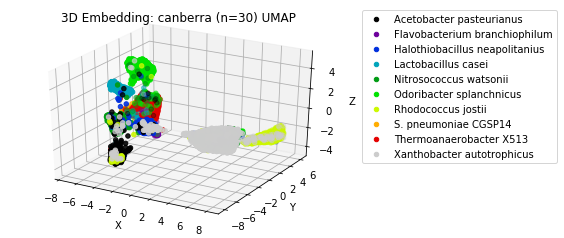

0.926744989633725


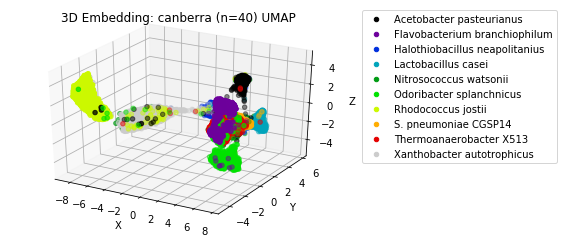

0.9232895646164478


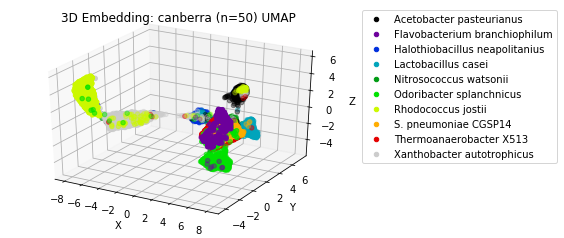

0.9292789679797282


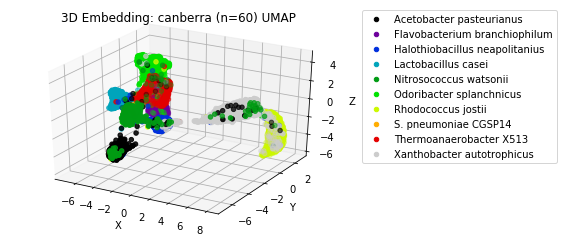

0.9288182446440912


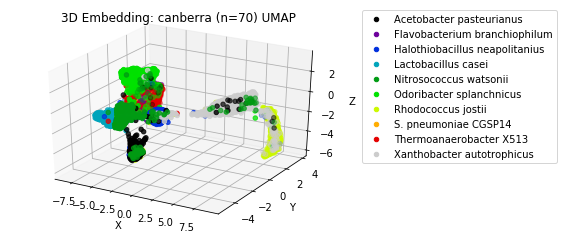

0.9202948629348077


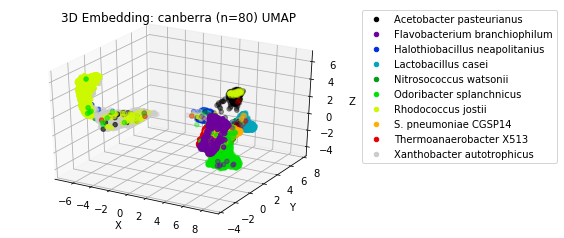

0.921907394609537


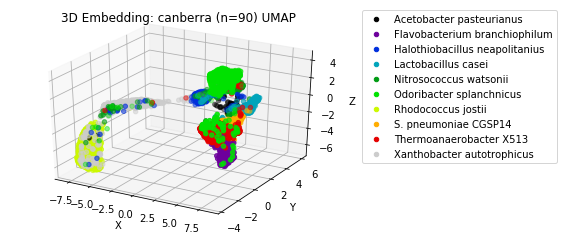

0.9276664363049989
canberra average classification score:  0.9255931812946326


In [69]:
metrics_list = ['manhattan', 'canberra']

scores = u_run_nonsense(metrics_list)

In [5]:
avg_scores = map(lambda x: np.mean(x), scores)
print(list(avg_scores))

[0.9335278609639356, 0.9296117126110216, 0.9080600987995597, 0.9264122450024317]


In [6]:
max_scores = map(lambda x: max(x), scores)
print(list(max_scores))

[0.9394148813637411, 0.9371112646855563, 0.9124625662289795, 0.9313522229900945]


In [5]:
def tsne_embed_3(perplexity):
    tsne = TSNE(n_components=3,perplexity=perplexity,n_jobs=6)
    t_embedding = tsne.fit_transform(pentamer_array)
    return t_embedding

def t_run_nonsense(perplexities, iterations, plot=True):
    tscores = []
    
    for perplexity in perplexities:
        tscores.append([])
        print('---------------------------------------------------------------')
        print('                     ' + str(perplexity) + '                   ')
        print('---------------------------------------------------------------')
        for i in range(iterations):
            t_embedding = tsne_embed_3(perplexity)
            if plot == True:
                plot_meta_3t(t_embedding, 'tSNE (perp=' + str(perplexity)+')')
            score = train_and_score(t_embedding, 0.4, 'rbf')
            tscores[-1].append(score)
            print(score)
        print(str(perplexity) + " average classification score: ", np.mean(tscores[-1]))
    return tscores

## Trying to optimize hyperparameters... running on all threads makes my computer freeze, so I kinda had to wing some of this. I think perplexities near 100 seem to perform best.

---------------------------------------------------------------
                     10                   
---------------------------------------------------------------


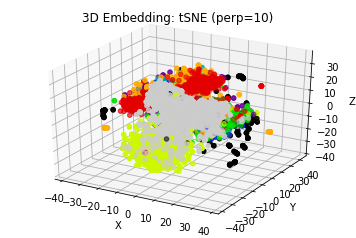

0.8576659767552938
10 average classification score:  0.8576659767552938
---------------------------------------------------------------
                     30                   
---------------------------------------------------------------


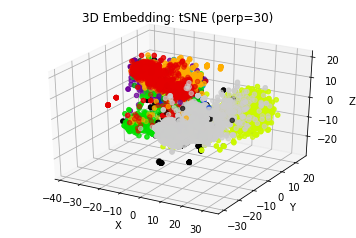

0.8688106989332909
30 average classification score:  0.8632383378442923
---------------------------------------------------------------
                     40                   
---------------------------------------------------------------


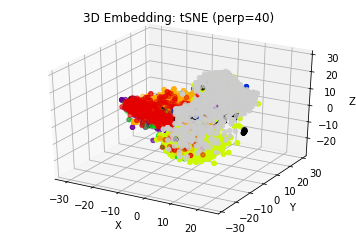

0.8670593854481771
40 average classification score:  0.8645120203789206
---------------------------------------------------------------
                     60                   
---------------------------------------------------------------


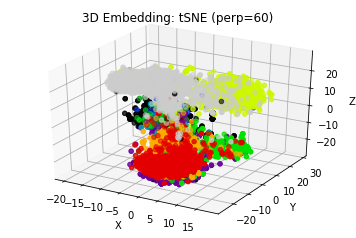

0.87215411558669
60 average classification score:  0.866422544180863
---------------------------------------------------------------
                     80                   
---------------------------------------------------------------


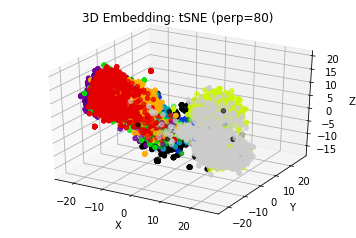

0.8762935838242318
80 average classification score:  0.8683967521095367
---------------------------------------------------------------
                     100                   
---------------------------------------------------------------


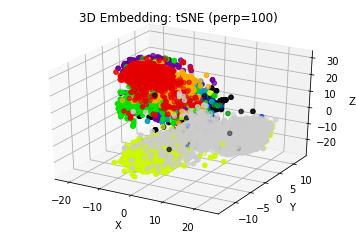

0.8715172743193759
100 average classification score:  0.8689168391445099


[0.8576659767552938,
 0.8688106989332909,
 0.8670593854481771,
 0.87215411558669,
 0.8762935838242318,
 0.8715172743193759]

In [8]:
perplexities = [10, 30, 40, 60, 80, 100]
t_run_nonsense(perplexities, 1)

In [ ]:
perpz = [60, 70]
fine_tune = t_run_nonsense(perpz, 5, plot=False)

---------------------------------------------------------------
                     60                   
---------------------------------------------------------------
0.86674096481452
0.872472536220347
0.8715172743193759
0.8680146473491482
0.8778856869925171
60 average classification score:  0.8713262219391815
---------------------------------------------------------------
                     70                   
---------------------------------------------------------------
0.8676962267154912
0.8732685878044897
0.8716764846362044
0.8702435917847476
0.8715172743193759
70 average classification score:  0.8708804330520618
---------------------------------------------------------------
                     80                   
---------------------------------------------------------------
0.8691291195669479


In [5]:
t_80 = t_run_nonsense([80], 5, plot=False)

---------------------------------------------------------------
                     80                   
---------------------------------------------------------------
0.8699251711510906
0.8756567425569177
0.8729501671708326
0.8754975322400892
0.8737462187549753
80 average classification score:  0.8735551663747811


In [10]:
umap_embedding = umap_embed_3(140, 'canberra')
t_embedding = tsne_embed_3(80)

In [6]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(umap_embedding)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

labels_true = contig_labels

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax = fig.add_subplot(111, projection='3d')

cmspec = plt.get_cmap("nipy_spectral")


ax.scatter(u_embedding[:,0], \
          u_embedding[:,1], \
          u_embedding[:,2], \
          c=labels, cmap=cmspec) 
    

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 7857
Homogeneity: 0.896
Completeness: 0.235
V-measure: 0.372
Adjusted Rand Index: 0.036
Adjusted Mutual Information: 0.110


NameError: name 'X' is not defined

Estimated number of clusters: 7857
Homogeneity: 0.896
Completeness: 0.235
V-measure: 0.372
Adjusted Rand Index: 0.036
Adjusted Mutual Information: 0.110


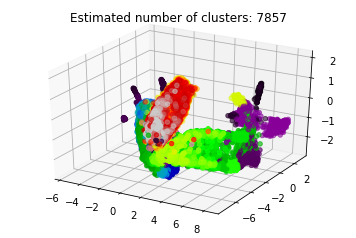

In [11]:

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')

fig = plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax = fig.add_subplot(111, projection='3d')

cmspec = plt.get_cmap("nipy_spectral")


ax.scatter(umap_embedding[:,0], \
          umap_embedding[:,1], \
          umap_embedding[:,2], \
          c=labels, cmap=cmspec) 
    

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

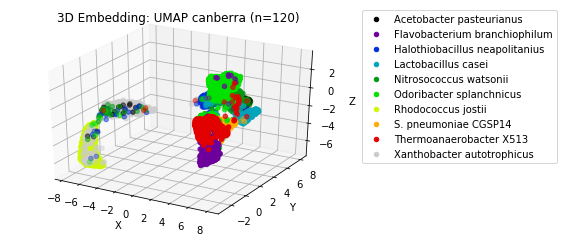

In [4]:
umap_embedding = umap_embed_3(140, 'canberra')
plot_meta_3(umap_embedding, 'canberra (n=120)', 'UMAP')

Estimated number of clusters: 572
Homogeneity: 0.786
Completeness: 0.264
V-measure: 0.395
Adjusted Rand Index: 0.023
Adjusted Mutual Information: 0.244


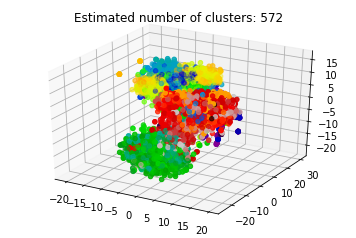

In [14]:
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(t_embedding)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
fig = plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
ax = fig.add_subplot(111, projection='3d')

cmspec = plt.get_cmap("nipy_spectral")


ax.scatter(t_embedding[:,0], \
          t_embedding[:,1], \
          t_embedding[:,2], \
          c=labels, cmap=cmspec) 
    

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [11]:
def plot_and_score_clustering(n_clusters_, labels, labels_true, embedding):
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, labels))

    # #############################################################################
    # Plot result
    import matplotlib.pyplot as plt
    from itertools import cycle

    plt.close('all')
    fig = plt.figure(1)
    plt.clf()

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    ax = fig.add_subplot(111, projection='3d')

    cmspec = plt.get_cmap("nipy_spectral")


    ax.scatter(embedding[:,0], \
              embedding[:,1], \
              embedding[:,2], \
              c=labels, cmap=cmspec) 


    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return

In [12]:
import hdbscan

In [13]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='canberra', min_cluster_size=250, min_samples=1, p=None)
cluster_labels = clusterer.fit_predict(umap_embedding)

Estimated number of clusters: 12
Homogeneity: 0.800
Completeness: 0.708
V-measure: 0.751
Adjusted Rand Index: 0.758
Adjusted Mutual Information: 0.707


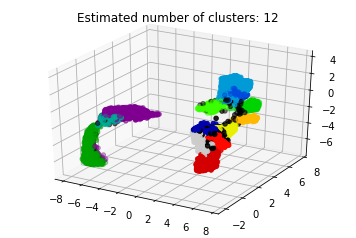

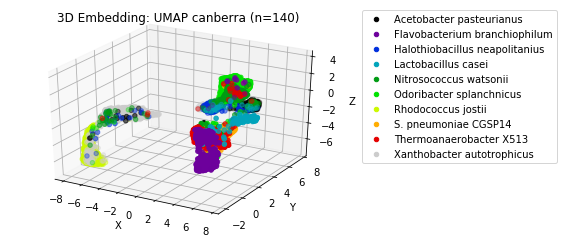

In [14]:
plot_and_score_clustering(cluster_labels.max(), cluster_labels, contig_labels, umap_embedding)
plot_meta_3(umap_embedding, 'canberra (n=140)', 'UMAP')

Estimated number of clusters: 11
Homogeneity: 0.687
Completeness: 0.642
V-measure: 0.664
Adjusted Rand Index: 0.627
Adjusted Mutual Information: 0.641


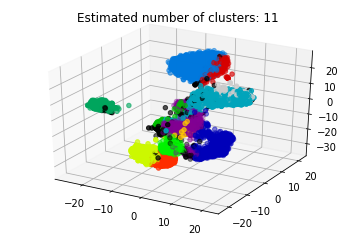

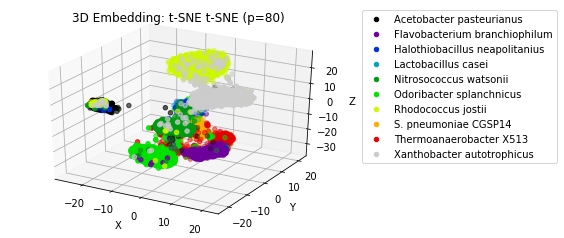

In [15]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='canberra', min_cluster_size=250, min_samples=10, p=None)
cluster_labels = clusterer.fit_predict(t_embedding)

plot_and_score_clustering(cluster_labels.max(), cluster_labels, contig_labels, t_embedding)
plot_meta_3(t_embedding, 't-SNE (p=80)', 't-SNE')

In [16]:
def score_clustering(n_clusters_, labels_true, labels, embedding):
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("==========================================================================================")
    print("==========================================================================================")
    print("==========================================================================================")
    
    homogeneity = metrics.homogeneity_score(labels_true, labels)
    completeness = metrics.completeness_score(labels_true, labels)
    v_measure = metrics.v_measure_score(labels_true, labels)
    ARI = metrics.adjusted_rand_score(labels_true, labels)
    AMI = metrics.adjusted_mutual_info_score(labels_true, labels)
    
    return homogeneity, completeness, v_measure, ARI, AMI

def umap_embed_ndim(neighbors, metric, dim):
    u_embedding = umap.UMAP(n_components=dim,
                            n_neighbors=neighbors,
                            min_dist=0.3,
                            metric=metric).fit_transform(pentamer_array)
    return u_embedding

def hdbscan_run(min_cluster_size, min_samples, embedding):
    clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='canberra', min_cluster_size=min_cluster_size, min_samples=min_samples, p=None)
    cluster_labels = clusterer.fit_predict(embedding)
    #Returns label assignments and # of clusters
    return cluster_labels, cluster_labels.max()

In [73]:
umap_embeddings = []
labels_list = []
scores = []

metrics_list = ["Homogeneity", "Completeness", "V-Measure", "ARI", "AMI"]

for i in range(3, 9):
    print("Beginning embedding: " + str(i) + " dimensions.")
    umap_embeddings.append(umap_embed_ndim(140, 'canberra', i))
    
    print("Beginning HDBSCAN.")
    labels, clusters = hdbscan_run(250, 1, umap_embeddings[-1])
    labels_list.append(labels)
    
    print("Scoring.")
    scores = score_clustering(clusters, contig_labels, labels, umap_embeddings[-1])
    to_print = zip(metrics_list, scores)
    
    for element in to_print:
        print(element)
    print("==========================================================================================")
    print("==========================================================================================")
    print("==========================================================================================")

Beginning embedding: 3 dimensions.
Beginning HDBSCAN.
Scoring.
Estimated number of clusters: 11
Homogeneity: 0.801
Completeness: 0.717
V-measure: 0.756
Adjusted Rand Index: 0.756
Adjusted Mutual Information: 0.716
('Homogeneity', 0.8006517059547095)
('Completeness', 0.7165928254254892)
('V-Measure', 0.7562937368176313)
('ARI', 0.7562400444422736)
('AMI', 0.7160022822910654)
Beginning embedding: 4 dimensions.
Beginning HDBSCAN.
Scoring.
Estimated number of clusters: 13
Homogeneity: 0.737
Completeness: 0.617
V-measure: 0.672
Adjusted Rand Index: 0.555
Adjusted Mutual Information: 0.616
('Homogeneity', 0.7370750107285285)
('Completeness', 0.616794610188956)
('V-Measure', 0.671591838532038)
('ARI', 0.5551392219093185)
('AMI', 0.6159225995360408)
Beginning embedding: 5 dimensions.
Beginning HDBSCAN.
Scoring.
Estimated number of clusters: 8
Homogeneity: 0.628
Completeness: 0.622
V-measure: 0.625
Adjusted Rand Index: 0.477
Adjusted Mutual Information: 0.621
('Homogeneity', 0.6275401188819828)

In [17]:
def optimize_hdbscan_hyperparameters(embedding):
    metrics_list = ["Homogeneity", "Completeness", "V-Measure", "ARI", "AMI"]
    best_mincs = 0
    best_V = 0
    best_minsamp = 0
    scores_list = []
    labels_clusters_list = []
    params_list = []

    for i in range(50, 500, 10):   
        for j in range(1, 11):
            params_list.append([i,j])
            labels, clusters = hdbscan_run(i, j, embedding)
            labels_clusters_list.append([labels, clusters])
            scores_list.append(score_clustering(clusters, contig_labels, labels, embedding))
            
    scores_list = np.asarray(scores_list)
    
    max_V = np.maximum(scores_list[:,2])
    
    print("Best parameters (V-Measure):")
    print("Min cluster size: " + str(best_mincs))
    print("Min sample size: " + str(best_minsamp))
    labels_clusters = hdbscan_run(best_mincs, best_minsamp, embedding)
    scores = score_clustering(clusters, contig_labels, labels, embedding)
    to_print = zip(metrics_list, scores)
    
    for element in to_print:
        print(element)
        
    return best_mincs, best_minsamp

In [93]:
ocho_best_mincs, ocho_best_minsamp = optimize_hdbscan_hyperparameters(umap_embeddings[-1])

Estimated number of clusters: 10
Homogeneity: 0.610
Completeness: 0.582
V-measure: 0.596
Adjusted Rand Index: 0.594
Adjusted Mutual Information: 0.581
Estimated number of clusters: 10
Homogeneity: 0.610
Completeness: 0.582
V-measure: 0.596
Adjusted Rand Index: 0.594
Adjusted Mutual Information: 0.581
Estimated number of clusters: 10
Homogeneity: 0.610
Completeness: 0.582
V-measure: 0.596
Adjusted Rand Index: 0.594
Adjusted Mutual Information: 0.581


KeyboardInterrupt: 

In [93]:
tres_best_mincs, tres_best_minsamp = optimize_hdbscan_hyperparameters(umap_embedding)

Estimated number of clusters: 16
Homogeneity: 0.800
Completeness: 0.666
V-measure: 0.727
Adjusted Rand Index: 0.707
Adjusted Mutual Information: 0.665
Estimated number of clusters: 16
Homogeneity: 0.800
Completeness: 0.666
V-measure: 0.727
Adjusted Rand Index: 0.707
Adjusted Mutual Information: 0.665
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 16
Homogeneity: 0.791
Completeness: 0.652
V-measure: 0.715
Adjusted Rand Index: 0.679
Adjusted Mutual Information: 0.651
Estimated number of clusters: 16
Homogeneity: 0.791
Completeness: 0.652
V-measure: 0.715
Adjusted Rand Index: 0.679
Adjusted Mutual Information: 0.651
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.800
Completeness: 0.670
V-measure: 0.729
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.669
Estimated number of clusters: 15
Homogeneity: 0.797
Completeness: 0.668
V-measure: 0.727
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.667
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.666
V-measure: 0.725
Adjusted Rand Index: 0.704
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.795
Completeness: 0.667
V-measure: 0.725
Adjusted Rand Index: 0.706
Adjusted Mutual Information: 0.666
Estimated number of clusters: 15
Homogeneity: 0.793
Completeness: 0.665
V-measure: 0.724
Adjusted Rand Index: 0.703
Adjusted Mutual Information: 0.664
Estimated number of clusters: 15
Homogeneity: 0.791
Completeness: 0.664
V-measure: 0.722
Adjus

Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.784
Completeness: 0.667
V-measure: 0.721
Adjusted Rand Index: 0.700
Adjusted Mutual Information: 0.666
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.669
V-measure: 0.723
Adjusted Rand Index: 0.699
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.670
V-measure: 0.723
Adjusted Rand Index: 0.701
Adjusted Mutual Information: 0.669
Estimated number of clusters: 14
Homogeneity: 0.785
Completeness: 0.669
V-measure: 0.722
Adjusted Rand Index: 0.698
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.782
Completeness: 0.668
V-measure: 0.720
Adjus

Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.784
Completeness: 0.667
V-measure: 0.721
Adjusted Rand Index: 0.700
Adjusted Mutual Information: 0.666
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.669
V-measure: 0.723
Adjusted Rand Index: 0.699
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.670
V-measure: 0.723
Adjusted Rand Index: 0.701
Adjusted Mutual Information: 0.669
Estimated number of clusters: 14
Homogeneity: 0.785
Completeness: 0.669
V-measure: 0.722
Adjusted Rand Index: 0.698
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.782
Completeness: 0.668
V-measure: 0.720
Adjus

Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.668
V-measure: 0.722
Adjusted Rand Index: 0.702
Adjusted Mutual Information: 0.667
Estimated number of clusters: 14
Homogeneity: 0.784
Completeness: 0.667
V-measure: 0.721
Adjusted Rand Index: 0.700
Adjusted Mutual Information: 0.666
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.669
V-measure: 0.723
Adjusted Rand Index: 0.699
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.786
Completeness: 0.670
V-measure: 0.723
Adjusted Rand Index: 0.701
Adjusted Mutual Information: 0.669
Estimated number of clusters: 14
Homogeneity: 0.785
Completeness: 0.669
V-measure: 0.722
Adjusted Rand Index: 0.698
Adjusted Mutual Information: 0.668
Estimated number of clusters: 14
Homogeneity: 0.782
Completeness: 0.668
V-measure: 0.720
Adjus

Estimated number of clusters: 13
Homogeneity: 0.785
Completeness: 0.679
V-measure: 0.728
Adjusted Rand Index: 0.709
Adjusted Mutual Information: 0.678
Estimated number of clusters: 13
Homogeneity: 0.785
Completeness: 0.679
V-measure: 0.728
Adjusted Rand Index: 0.709
Adjusted Mutual Information: 0.678
Estimated number of clusters: 13
Homogeneity: 0.784
Completeness: 0.677
V-measure: 0.727
Adjusted Rand Index: 0.707
Adjusted Mutual Information: 0.677
Estimated number of clusters: 13
Homogeneity: 0.787
Completeness: 0.680
V-measure: 0.729
Adjusted Rand Index: 0.707
Adjusted Mutual Information: 0.679
Estimated number of clusters: 13
Homogeneity: 0.786
Completeness: 0.681
V-measure: 0.730
Adjusted Rand Index: 0.708
Adjusted Mutual Information: 0.680
Estimated number of clusters: 13
Homogeneity: 0.784
Completeness: 0.679
V-measure: 0.728
Adjusted Rand Index: 0.705
Adjusted Mutual Information: 0.678
Estimated number of clusters: 13
Homogeneity: 0.782
Completeness: 0.678
V-measure: 0.726
Adjus

Estimated number of clusters: 12
Homogeneity: 0.764
Completeness: 0.680
V-measure: 0.720
Adjusted Rand Index: 0.691
Adjusted Mutual Information: 0.680
Estimated number of clusters: 12
Homogeneity: 0.764
Completeness: 0.680
V-measure: 0.720
Adjusted Rand Index: 0.691
Adjusted Mutual Information: 0.680
Estimated number of clusters: 12
Homogeneity: 0.762
Completeness: 0.679
V-measure: 0.718
Adjusted Rand Index: 0.689
Adjusted Mutual Information: 0.678
Estimated number of clusters: 11
Homogeneity: 0.740
Completeness: 0.672
V-measure: 0.704
Adjusted Rand Index: 0.680
Adjusted Mutual Information: 0.671
Estimated number of clusters: 11
Homogeneity: 0.740
Completeness: 0.672
V-measure: 0.705
Adjusted Rand Index: 0.682
Adjusted Mutual Information: 0.672
Estimated number of clusters: 11
Homogeneity: 0.739
Completeness: 0.671
V-measure: 0.703
Adjusted Rand Index: 0.680
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.718
Completeness: 0.669
V-measure: 0.692
Adjus

Estimated number of clusters: 11
Homogeneity: 0.747
Completeness: 0.677
V-measure: 0.710
Adjusted Rand Index: 0.685
Adjusted Mutual Information: 0.677
Estimated number of clusters: 11
Homogeneity: 0.747
Completeness: 0.677
V-measure: 0.710
Adjusted Rand Index: 0.685
Adjusted Mutual Information: 0.677
Estimated number of clusters: 11
Homogeneity: 0.745
Completeness: 0.675
V-measure: 0.709
Adjusted Rand Index: 0.683
Adjusted Mutual Information: 0.675
Estimated number of clusters: 11
Homogeneity: 0.740
Completeness: 0.672
V-measure: 0.704
Adjusted Rand Index: 0.680
Adjusted Mutual Information: 0.671
Estimated number of clusters: 10
Homogeneity: 0.720
Completeness: 0.672
V-measure: 0.695
Adjusted Rand Index: 0.669
Adjusted Mutual Information: 0.671
Estimated number of clusters: 10
Homogeneity: 0.719
Completeness: 0.670
V-measure: 0.694
Adjusted Rand Index: 0.667
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.718
Completeness: 0.669
V-measure: 0.692
Adjus

Estimated number of clusters: 11
Homogeneity: 0.747
Completeness: 0.677
V-measure: 0.710
Adjusted Rand Index: 0.685
Adjusted Mutual Information: 0.677
Estimated number of clusters: 11
Homogeneity: 0.747
Completeness: 0.677
V-measure: 0.710
Adjusted Rand Index: 0.685
Adjusted Mutual Information: 0.677
Estimated number of clusters: 10
Homogeneity: 0.724
Completeness: 0.674
V-measure: 0.698
Adjusted Rand Index: 0.669
Adjusted Mutual Information: 0.674
Estimated number of clusters: 10
Homogeneity: 0.719
Completeness: 0.671
V-measure: 0.694
Adjusted Rand Index: 0.667
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.720
Completeness: 0.672
V-measure: 0.695
Adjusted Rand Index: 0.669
Adjusted Mutual Information: 0.671
Estimated number of clusters: 10
Homogeneity: 0.719
Completeness: 0.670
V-measure: 0.694
Adjusted Rand Index: 0.667
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.718
Completeness: 0.669
V-measure: 0.692
Adjus

Estimated number of clusters: 10
Homogeneity: 0.726
Completeness: 0.677
V-measure: 0.700
Adjusted Rand Index: 0.671
Adjusted Mutual Information: 0.676
Estimated number of clusters: 10
Homogeneity: 0.726
Completeness: 0.677
V-measure: 0.700
Adjusted Rand Index: 0.671
Adjusted Mutual Information: 0.676
Estimated number of clusters: 10
Homogeneity: 0.724
Completeness: 0.674
V-measure: 0.698
Adjusted Rand Index: 0.669
Adjusted Mutual Information: 0.674
Estimated number of clusters: 10
Homogeneity: 0.719
Completeness: 0.671
V-measure: 0.694
Adjusted Rand Index: 0.667
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.720
Completeness: 0.672
V-measure: 0.695
Adjusted Rand Index: 0.669
Adjusted Mutual Information: 0.671
Estimated number of clusters: 10
Homogeneity: 0.719
Completeness: 0.670
V-measure: 0.694
Adjusted Rand Index: 0.667
Adjusted Mutual Information: 0.670
Estimated number of clusters: 10
Homogeneity: 0.718
Completeness: 0.669
V-measure: 0.692
Adjus

Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.705
Completeness: 0.672
V-measure: 0.688
Adjusted Rand Index: 0.661
Adjusted Mutual Information: 0.671
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.668
V-measure: 0.684
Adjusted Rand Index: 0.658
Adjusted Mutual Information: 0.667
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.669
V-measure: 0.684
Adjusted Rand Index: 0.660
Adjusted Mutual Information: 0.668
Estimated number of clusters: 9
Homogeneity: 0.699
Completeness: 0.667
V-measure: 0.683
Adjusted Rand Index: 0.659
Adjusted Mutual Information: 0.667
Estimated number of clusters: 9
Homogeneity: 0.697
Completeness: 0.666
V-measure: 0.681
Adjusted Ran

Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.705
Completeness: 0.672
V-measure: 0.688
Adjusted Rand Index: 0.661
Adjusted Mutual Information: 0.671
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.668
V-measure: 0.684
Adjusted Rand Index: 0.658
Adjusted Mutual Information: 0.667
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.669
V-measure: 0.684
Adjusted Rand Index: 0.660
Adjusted Mutual Information: 0.668
Estimated number of clusters: 9
Homogeneity: 0.699
Completeness: 0.667
V-measure: 0.683
Adjusted Rand Index: 0.659
Adjusted Mutual Information: 0.667
Estimated number of clusters: 9
Homogeneity: 0.697
Completeness: 0.666
V-measure: 0.681
Adjusted Ran

Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.707
Completeness: 0.674
V-measure: 0.690
Adjusted Rand Index: 0.663
Adjusted Mutual Information: 0.674
Estimated number of clusters: 9
Homogeneity: 0.705
Completeness: 0.672
V-measure: 0.688
Adjusted Rand Index: 0.661
Adjusted Mutual Information: 0.671
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.668
V-measure: 0.684
Adjusted Rand Index: 0.658
Adjusted Mutual Information: 0.667
Estimated number of clusters: 9
Homogeneity: 0.700
Completeness: 0.669
V-measure: 0.684
Adjusted Rand Index: 0.660
Adjusted Mutual Information: 0.668
Estimated number of clusters: 9
Homogeneity: 0.699
Completeness: 0.667
V-measure: 0.683
Adjusted Rand Index: 0.659
Adjusted Mutual Information: 0.667
Estimated number of clusters: 8
Homogeneity: 0.669
Completeness: 0.672
V-measure: 0.670
Adjusted Ran

Estimated number of clusters: 8
Homogeneity: 0.678
Completeness: 0.680
V-measure: 0.679
Adjusted Rand Index: 0.628
Adjusted Mutual Information: 0.677
Estimated number of clusters: 8
Homogeneity: 0.678
Completeness: 0.680
V-measure: 0.679
Adjusted Rand Index: 0.628
Adjusted Mutual Information: 0.677
Estimated number of clusters: 8
Homogeneity: 0.676
Completeness: 0.678
V-measure: 0.677
Adjusted Rand Index: 0.627
Adjusted Mutual Information: 0.675
Estimated number of clusters: 8
Homogeneity: 0.672
Completeness: 0.675
V-measure: 0.673
Adjusted Rand Index: 0.625
Adjusted Mutual Information: 0.671
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.672
Adjusted Rand Index: 0.613
Adjusted Mutual Information: 0.659
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.658
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Ran

Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.665
Completeness: 0.689
V-measure: 0.677
Adjusted Rand Index: 0.616
Adjusted Mutual Information: 0.665
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.673
Adjusted Rand Index: 0.614
Adjusted Mutual Information: 0.660
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.672
Adjusted Rand Index: 0.613
Adjusted Mutual Information: 0.659
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.658
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Ran

Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.665
Completeness: 0.689
V-measure: 0.677
Adjusted Rand Index: 0.616
Adjusted Mutual Information: 0.665
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.673
Adjusted Rand Index: 0.614
Adjusted Mutual Information: 0.660
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.672
Adjusted Rand Index: 0.613
Adjusted Mutual Information: 0.659
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.658
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Ran

Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.665
Completeness: 0.689
V-measure: 0.677
Adjusted Rand Index: 0.616
Adjusted Mutual Information: 0.665
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.673
Adjusted Rand Index: 0.614
Adjusted Mutual Information: 0.660
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.672
Adjusted Rand Index: 0.613
Adjusted Mutual Information: 0.659
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.658
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Ran

Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.666
Completeness: 0.690
V-measure: 0.678
Adjusted Rand Index: 0.617
Adjusted Mutual Information: 0.666
Estimated number of clusters: 7
Homogeneity: 0.665
Completeness: 0.689
V-measure: 0.677
Adjusted Rand Index: 0.616
Adjusted Mutual Information: 0.665
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.673
Adjusted Rand Index: 0.614
Adjusted Mutual Information: 0.660
Estimated number of clusters: 7
Homogeneity: 0.660
Completeness: 0.685
V-measure: 0.672
Adjusted Rand Index: 0.613
Adjusted Mutual Information: 0.659
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.658
Estimated number of clusters: 7
Homogeneity: 0.658
Completeness: 0.684
V-measure: 0.671
Adjusted Ran